<a href="https://colab.research.google.com/github/Stephyj2/Brain-MRI-Images-for-Brain-Tumor-Detection/blob/main/Brain_Tumor_Detection_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Tumor Detection Using MRI Scans

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load and Preprocess Dataset

In [3]:

# Define the paths to the images
data_path = '/content/drive/MyDrive/brain_tumor_dataset'  # Update with your dataset path
categories = ['no', 'yes']  # 'no' for no tumor, 'yes' for tumor

# Preprocessing parameters
img_size = 128  # Resize all images to 128x128

# Load and resize the images
def load_data():
    data = []
    for category in categories:
        path = os.path.join(data_path, category)
        class_num = categories.index(category)  # Assign labels 0 for 'no' and 1 for 'yes'
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_img = cv2.resize(img_array, (img_size, img_size))
                data.append([resized_img, class_num])
            except Exception as e:
                pass
    return data

# Load data
dataset = load_data()

# Shuffle the dataset
import random
random.shuffle(dataset)

# Split features and labels
X = []
y = []
for features, label in dataset:
    X.append(features)
    y.append(label)

# Convert lists to arrays
X = np.array(X).reshape(-1, img_size, img_size, 1)
y = np.array(y)

# Normalize the images (scale pixel values to range [0,1])
X = X / 255.0


## Split the Dataset into Training and Testing Sets

In [4]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Data Augmentation

In [5]:

datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    fill_mode="nearest"
)

# Train data generator
train_generator = datagen.flow(X_train, y_train, batch_size=32)


## Build the CNN Model

In [6]:

model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 2nd Convolutional Layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 3rd Convolutional Layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the layers
model.add(Flatten())

# Fully Connected Layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout to prevent overfitting
model.add(Dense(1, activation='sigmoid'))  # Binary classification output layer

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model Summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,193 (12.60 MB)

 Trainable params: 3,304,193 (12.60 MB)

 Non-trainable params: 0 (0.00 B)

## Train the Model

In [7]:
# Train the model
history = model.fit(train_generator, epochs=20, validation_data=(X_test, y_test))


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.6272 - loss: 0.6912 - val_accuracy: 0.6863 - val_loss: 0.6016
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 964ms/step - accuracy: 0.6128 - loss: 0.6425 - val_accuracy: 0.7451 - val_loss: 0.6385
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6176 - loss: 0.6398 - val_accuracy: 0.6863 - val_loss: 0.5968
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 951ms/step - accuracy: 0.6406 - loss: 0.6272 - val_accuracy: 0.7451 - val_loss: 0.6004
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6911 - loss: 0.6071 - val_accuracy: 0.6863 - val_loss: 0.6010
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7084 - loss: 0.5796 - val_accuracy: 0.6667 - val_loss: 0.6125
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6589 - loss: 0.5845 - val_accuracy: 0.7255 - val_loss: 0.6033
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 961ms/step - accuracy: 0.6648 - loss: 0.6164 - val_accuracy: 0.7451 - val_loss: 0.5876
Epoch 9/20
7/7 ━

## Evaluate the Model

In [8]:

# Evaluate model performance
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.7286 - loss: 0.6816
Test accuracy: 0.7647


## Visualize Training Results

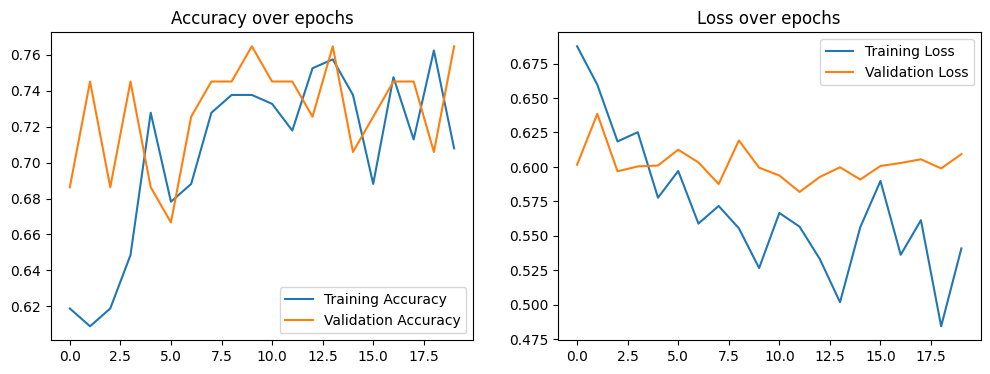

In [9]:

# Plot accuracy and loss over epochs
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.legend()

plt.show()


## Save the Model (Optional)

In [10]:

model.save('brain_tumor_detector.h5')


## Test on New Images (Optional)

In [13]:
import cv2
import numpy as np

def predict_image(img_path):
    # Replace 'path_to_test_image' with the actual path to your image
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Check if the image was loaded successfully
    if img is None:
        print(f"Error: Could not load image from {img_path}. Check the file path and permissions.")
        return "Error: Image not loaded" # or raise an exception

    img = cv2.resize(img, (img_size, img_size))
    img = img.reshape(1, img_size, img_size, 1) / 255.0
    prediction = model.predict(img)
    return "Tumor" if prediction[0][0] > 0.5 else "No Tumor"

# Test on a sample image
# Make sure to replace 'path/to/your/test_image.jpg' with the actual path
print(predict_image('path/to/your/test_image.jpg'))

Error: Could not load image from path/to/your/test_image.jpg. Check the file path and permissions.
Error: Image not loaded
